## Here we will be loading the wind experiment and then recalculate correlatins
## EASTERLIES

### Good examples to follow
#### - https://github.com/adele157/easterlies-collaborative-project/blob/master/notebooks/example_notebook.ipynb
#### - https://github.com/adele157/easterlies-collaborative-project/blob/master/notebooks/figures/Figure-8.ipynb


In [1]:
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

#to use the catalog
import intake

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

from dask.distributed import Client

figdir = '/g/data/jk72/ns3783'

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38287/status,
Dashboard: /proxy/38287/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34281,Workers: 7
Dashboard: /proxy/38287/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:45881,Total threads: 4
Dashboard: /proxy/37463/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:40369,


#### These lines below used to work, but now they do not. Keeping it for reference.

### Opening the catalog according to this tutorial: https://github.com/adele-morrison/cosima-recipes/blob/master/Tutorials/ACCESS-NRI_Intake_Catalog.ipynb
#### The problem is I had to request access to one of the projects and can't proceed with this approach if I want it to get this done today.


### Try to access data through creating my own database in accordance with this tutorial: https://github.com/adele-morrison/cosima-recipes/blob/master/Tutorials/Make_Your_Own_Database.ipynb

In [2]:
#pwd

In [3]:
db = 'local_cc_test.db'
session = cc.database.create_session(db)

In [4]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,01deg_jra55v13_ryf9091_easterlies_up10_zonal,378
1,01deg_jra55v13_ryf9091_easterlies_up10,540
2,01deg_jra55_ryf_Control,384


In [5]:
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'

In [6]:
# plot anomalies for last 5 years of simulation:
start_time='2150-01-01'   #try with 2150 again?
end_time='2159-12-31'

depth_slice = slice(400, 6000)
#lat_slice  = slice(-79,-59)
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)


## load temp
temp_up = cc.querying.getvar(experiment_eup,'temp',session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_upY = temp_up.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                      
temp_upY = temp_upY.load()

temp_up = cc.querying.getvar(easterlies_up_zonal,'temp', session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_upX = temp_up.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                           
temp_upX = temp_upX.load()

In [7]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

In [8]:
temp_con = cc.querying.getvar(control,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                             
temp_con = temp_con.load()

In [9]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_con.yt_ocean,'xt_ocean':temp_con.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(control,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_con = (temp_con*thickness).sum('st_ocean')/thickness.sum('st_ocean')
temp_upX = (temp_upX*thickness).sum('st_ocean')/thickness.sum('st_ocean')
temp_upY = (temp_upY*thickness).sum('st_ocean')/thickness.sum('st_ocean')


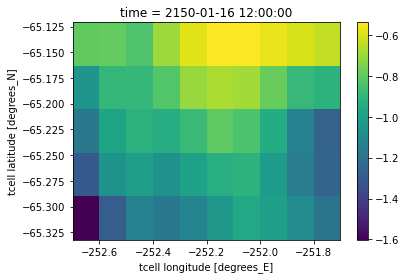

In [10]:
##test if temp is still working after the depth weighting
temp_upY[0,...].plot()
#temp_upY.plot()

In [11]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar(control,'area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_con = (temp_con*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum
temp_upX = (temp_upX*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum
temp_upY = (temp_upY*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum

In [12]:
temp_upY

<xarray.DataArray (time: 120)>
dask.array<truediv, shape=(120,), dtype=float64, chunksize=(120,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2150-01-16 12:00:00 ... 2159-12-16 12:00:00

In [13]:
temp_con = temp_con.load()
temp_upX = temp_upX.load()
temp_upY = temp_upY.load()

### main plot

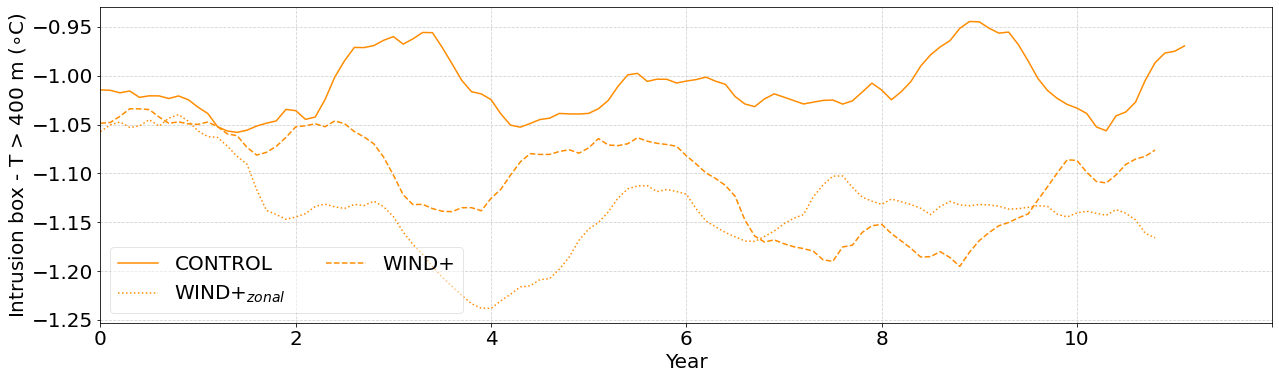

In [14]:
plt.rcParams['font.size'] = 20
fig = plt.figure(figsize = (21, 18))

plt.subplots_adjust(hspace = 0.05)

ax1 = plt.subplot(3, 1, 2)
plt.plot((temp_con).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'darkorange', label = 'CONTROL')
plt.plot((temp_upX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'darkorange', linestyle = ':', label = 'WIND+$_{zonal}$')
plt.plot((temp_upY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'darkorange', linestyle = '--', label = 'WIND+')

ax1.set_xlim(0,120)

ax1.set_xticklabels(np.arange(0, 12, 2))
ax1.grid(linestyle = '--', color = 'lightgrey')
ax1.set_ylabel('Intrusion box - T > 400 m ($\circ$C)')
ax1.set_xlabel('Year')
a=ax1.legend(ncol = 2, loc = 'lower left',fancybox=True, framealpha=0.5)


figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/fig8a_easterlies_series_wind+.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')


### LOAD ASC HEAT TRANSPORT ZONAL

### LOAD ASC SPEED

### LOAD ISOPYCNAL DEPTH

##### MAKE MASK FOR BOX 1 offshore in between 1000 and 2000 isopycnals

#### Load this new variables to guarantee plots will run smoothly 

#try detrending to see if there is something here on this graph that changes


## First run the function to detrend the time series later on 

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [38]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [39]:
temp_cond = detrend_dim(temp_con,'time')
temp_upXd = detrend_dim(temp_upX,'time')
temp_upYd = detrend_dim(temp_upY,'time')

# asc_uspeed_cond = detrend_dim(asc_uspeed_con,'time')
# asc_uspeed_upXd = detrend_dim(asc_uspeed_upX,'time')
# asc_uspeed_upYd = detrend_dim(asc_uspeed_upY,'time')

# asc_heatx_cond = detrend_dim(asc_heatx_con,'time')
# asc_heatx_upXd = detrend_dim(asc_heatx_upX,'time')
# asc_heatx_upYd = detrend_dim(asc_heatx_upY,'time')

isocon_offd = detrend_dim(isocon_off,'time')
isocon_offXd = detrend_dim(isocon_offX,'time')
isocon_offYd = detrend_dim(isocon_offY,'time')

### Plot

Text(0, 0.5, 'Isopycnal 27.82 (m)')

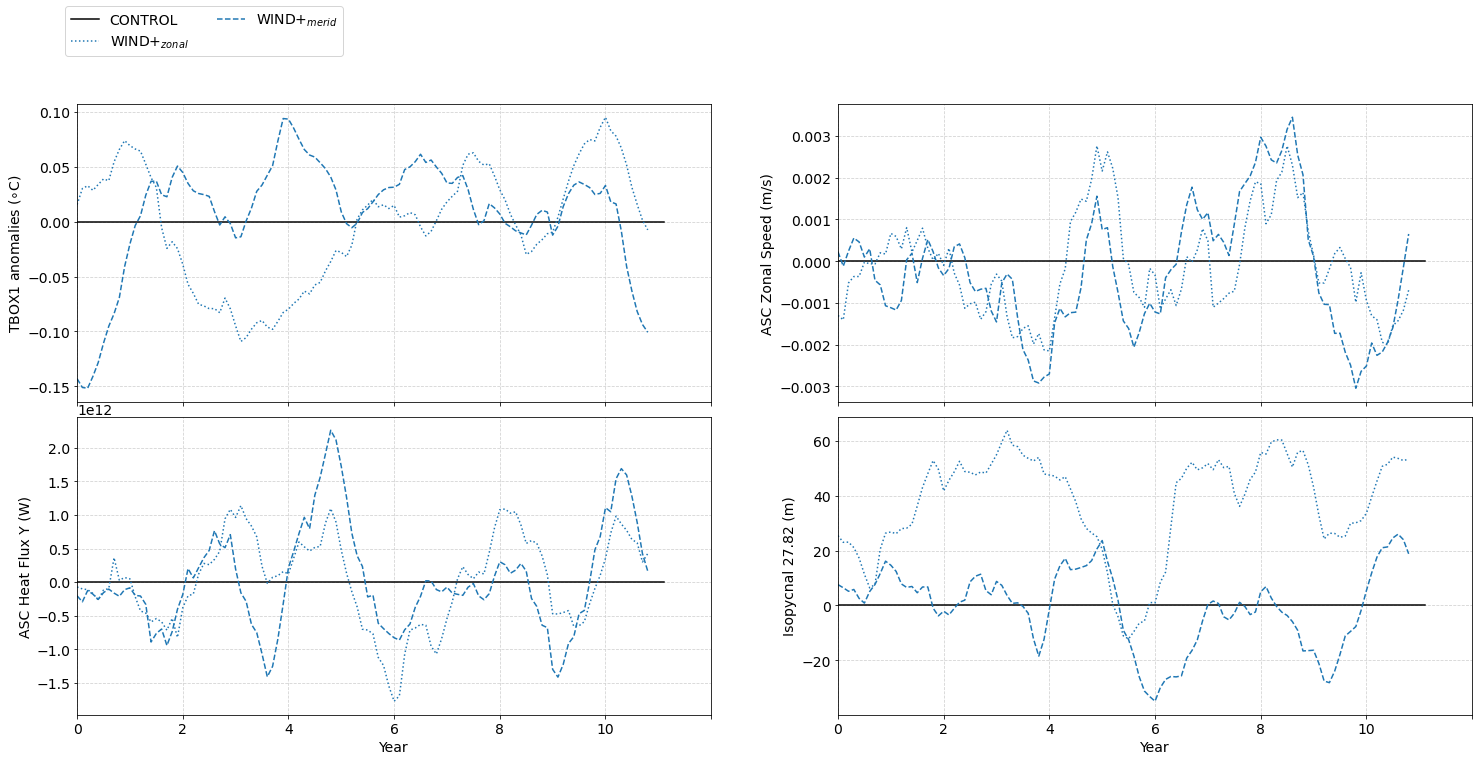

In [38]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (25, 17))
axs = [fig.add_subplot(321), fig.add_subplot(322), fig.add_subplot(323),fig.add_subplot(324)]
plt.subplots_adjust(hspace = 0.05)


axs[0].plot((temp_cond-temp_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[0].plot((temp_upXd-temp_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[0].plot((temp_upYd-temp_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')
    
axs[0].legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.2,1.35))

axs[1].plot((asc_uspeed_cond-asc_uspeed_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[1].plot((asc_uspeed_upXd-asc_uspeed_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[1].plot((asc_uspeed_upYd-asc_uspeed_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[2].plot((asc_heatx_cond-asc_heatx_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[2].plot((asc_heatx_upXd-asc_heatx_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[2].plot((asc_heatx_upYd-asc_heatx_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[3].plot((isocon_off-isocon_off).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[3].plot((isocon_offX-isocon_off).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[3].plot((isocon_offY-isocon_off).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[0].set_xlim(0,120)
axs[1].set_xlim(0,120)
axs[2].set_xlim(0,120)
axs[3].set_xlim(0,120)
#axs[2].set_ylim(-1.51, 0.25)

axs[2].set_xticklabels(np.arange(0, 12, 2))
axs[3].set_xticklabels(np.arange(0, 12, 2))
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[2].grid(linestyle = '--', color = 'lightgrey')
axs[3].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('TBOX1 anomalies ($\circ$C)')
axs[2].set_xlabel('Year')
axs[3].set_xlabel('Year')
axs[1].set_ylabel('ASC Zonal Speed (m/s)')
axs[2].set_ylabel('ASC Heat Flux Y (W)')
axs[3].set_ylabel('Isopycnal 27.82 (m)')

#figdir = '/g/data/jk72/ns3783'
#filestr = figdir+'/Figure8.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [34]:
#varlist = cc.querying.get_variables(master_session, control)
#varlist[varlist['name'].str.lower().str.match('heat_')]

## Plot 2

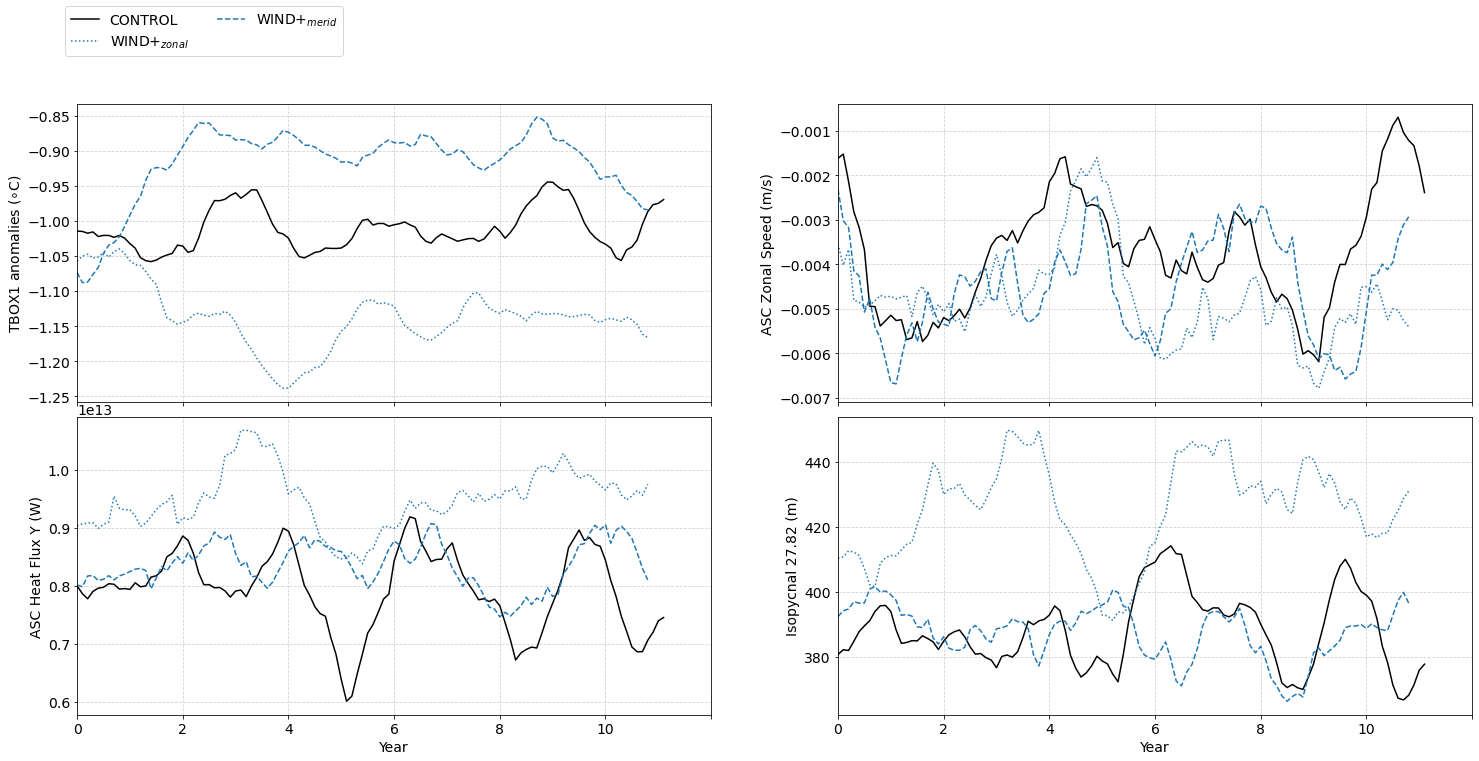

In [43]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (25, 17))
axs = [fig.add_subplot(321), fig.add_subplot(322), fig.add_subplot(323),fig.add_subplot(324)]
plt.subplots_adjust(hspace = 0.05)


axs[0].plot((temp_con).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[0].plot((temp_upX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[0].plot((temp_upY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')
    
axs[0].legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.2,1.35))

axs[1].plot((asc_uspeed_con).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[1].plot((asc_uspeed_upX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[1].plot((asc_uspeed_upY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[2].plot((asc_heatx_con).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[2].plot((asc_heatx_upX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[2].plot((asc_heatx_upY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[3].plot((isocon_off).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[3].plot((isocon_offX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[3].plot((isocon_offY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[0].set_xlim(0,120)
axs[1].set_xlim(0,120)
axs[2].set_xlim(0,120)
axs[3].set_xlim(0,120)
#axs[2].set_ylim(-1.51, 0.25)

axs[2].set_xticklabels(np.arange(0, 12, 2))
axs[3].set_xticklabels(np.arange(0, 12, 2))
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[2].grid(linestyle = '--', color = 'lightgrey')
axs[3].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('TBOX1 anomalies ($\circ$C)')
axs[2].set_xlabel('Year')
axs[3].set_xlabel('Year')
axs[1].set_ylabel('ASC Zonal Speed (m/s)')
axs[2].set_ylabel('ASC Heat Flux Y (W)')
axs[3].set_ylabel('Isopycnal 27.82 (m)')

figdir = '/g/data/jk72/ns3783'
filestr = figdir+'/Figure8_noanomalia.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

## Plot 3

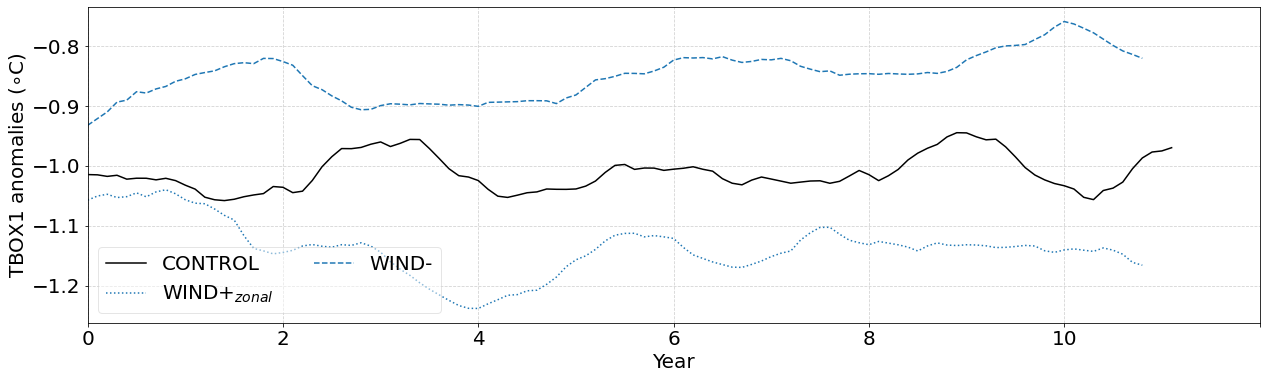

In [32]:
plt.rcParams['font.size'] = 20
fig = plt.figure(figsize = (21, 18))

plt.subplots_adjust(hspace = 0.05)

ax1 = plt.subplot(3, 1, 2)
plt.plot((temp_con).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
plt.plot((temp_upX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
plt.plot((temp_upY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND-')

ax1.set_xlim(0,120)

ax1.set_xticklabels(np.arange(0, 12, 2))
ax1.grid(linestyle = '--', color = 'lightgrey')
ax1.set_ylabel('Intrusion box - T > 400 m ($\circ$C)')
ax1.set_xlabel('Year')
a=ax1.legend(ncol = 2, loc = 'lower left',fancybox=True, framealpha=0.5)

figdir = '/home/581/ns3783/Scripts/Figures/Current'
filestr = figdir+'/fig8a_easterlies_series_wind-.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')